# NumberOfTrips は正規分布に近づけても、学習度合いがあまり変わらなかったため、そのまま
メモ：この特徴量はカテゴリとしても扱える。訓練テストどちらも数値が共通しているから。

In [1]:
import os
os.chdir('../../')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scr.util import *

In [3]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.pipeline import Pipeline

In [4]:
df_train = pd.read_csv('data/null_survey/train_age_income_ok.csv')
df_test = pd.read_csv('data/null_survey/test_age_income_ok.csv')

In [5]:
df_train.isna().sum()

id                        0
Age                       0
TypeofContact             0
CityTier                  0
DurationOfPitch           0
Occupation                0
Gender                    0
NumberOfPersonVisiting    0
NumberOfFollowups         0
ProductPitched            0
PreferredPropertyStar     0
NumberOfTrips             0
Passport                  0
PitchSatisfactionScore    0
Designation               0
MonthlyIncome             0
ProdTaken                 0
Marry                     0
Car                       0
Child                     0
AgeGroup                  0
dtype: int64

In [6]:
df_test.isna().sum()

id                          0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch           131
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips              42
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome               0
Marry                       0
Car                         0
Child                       0
AgeGroup                    0
dtype: int64

<Axes: >

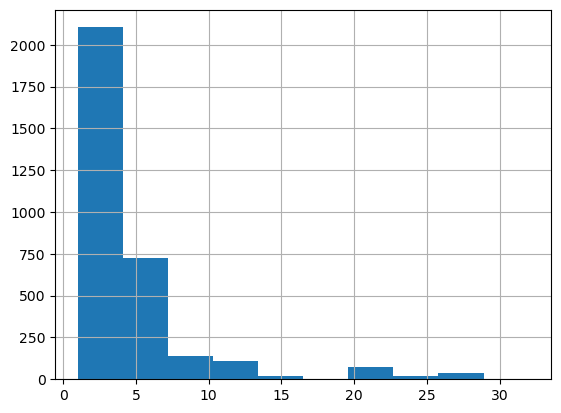

In [7]:
df_train['NumberOfTrips'].hist()

<Axes: >

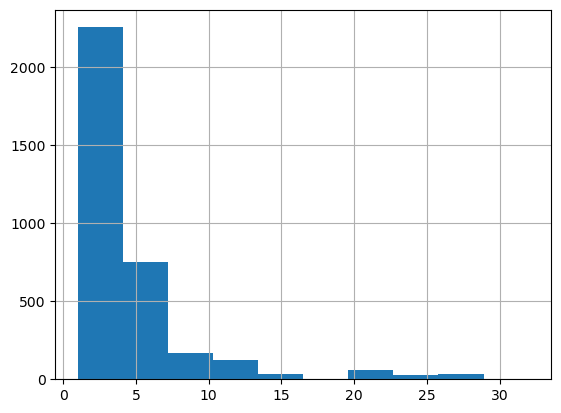

In [8]:
df_test['NumberOfTrips'].hist()

In [9]:
df_train['NumberOfTrips'].value_counts()

NumberOfTrips
2     957
3     640
5     417
1     323
7     213
4     185
8     142
12    110
6      97
20     75
28     37
24     20
16     19
32      2
Name: count, dtype: int64

In [10]:
df_test['NumberOfTrips'].value_counts()

NumberOfTrips
2.0     953
3.0     762
5.0     400
1.0     330
7.0     226
4.0     208
8.0     165
6.0     125
12.0    124
20.0     62
16.0     31
28.0     31
24.0     26
32.0      4
Name: count, dtype: int64

In [27]:
# NumberOfTripを正規分布に近づける。

# df_train['NumberOfTrips'] = np.log1p(df_train['NumberOfTrips'])
# df_test['NumberOfTrips'] = np.log1p(df_test['NumberOfTrips'])

<Axes: >

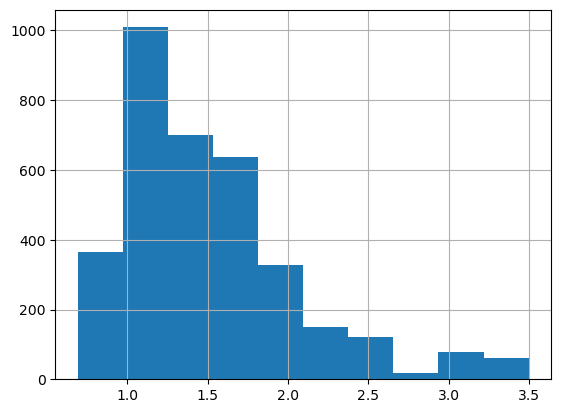

In [28]:
# df_train['NumberOfTrips'].hist()

<Axes: >

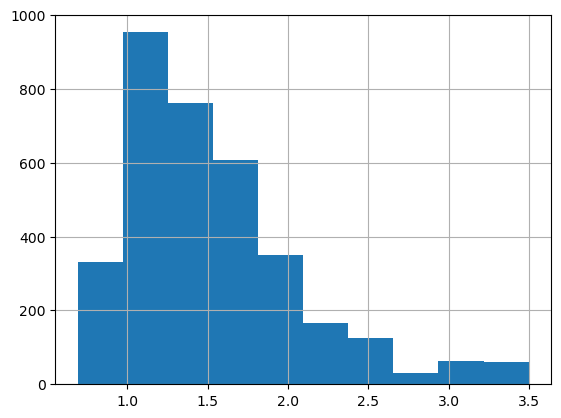

In [29]:
# df_test['NumberOfTrips'].hist()

In [30]:
# df_train['NumberOfTrips'].isna().sum()

22

In [31]:
# df_test['NumberOfTrips'].isna().sum()

42

# 今回調査する欠損値：Age, DurationOfPitch, *NumberOfTrips*, MonthlyIncome

# NumberOfTrips

In [11]:
df_all = pd.concat([df_train, df_test], axis=0)

In [12]:
# NumberOfTrips を予測するための特徴量を選択
predict_trips_features = ['Age', 'TypeofContact','CityTier','Occupation','Gender','NumberOfPersonVisiting',
                        'NumberOfFollowups','ProductPitched','PreferredPropertyStar','PitchSatisfactionScore', 'Passport','Designation','MonthlyIncome' ,'Marry', 'Car','Child', 'AgeGroup']

# 主キー用idを取得
# id_train = df_train.loc[df_train['NumberOfTrips'].isna()].index
id_test = df_test.loc[df_test['NumberOfTrips'].isna(), 'id'].values

# 目的変数をNumberOfTripsとする
X_train_predict_trips = df_all.loc[~(df_all['NumberOfTrips'].isna()), predict_trips_features]
X_test_predict_trips = df_all.loc[df_all['NumberOfTrips'].isna(), predict_trips_features]
y_train_predict_trips = df_all.loc[~(df_all['NumberOfTrips'].isna()), 'NumberOfTrips']
y_test_predict_trips = None

In [15]:
X_train_predict_trips = mapping_columns_if_exist(X_train_predict_trips)
X_test_predict_trips = mapping_columns_if_exist(X_test_predict_trips)
X_train_predict_trips, X_test_predict_trips = feature_to_int(X_train_predict_trips, X_test_predict_trips)

In [20]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_list = list(kf.split(X_train_predict_trips, y_train_predict_trips))

def train_catboost(X, y, cv, params: dict = None):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records, ))
    for i, (tr_idx, va_idx) in enumerate(cv):
        tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
        model = cb.CatBoostRegressor(**params)
        model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
        oof_pred[va_idx] = model.predict(va_x)
        models.append(model)
    return oof_pred, models

params = {
    'loss_function': 'Quantile:alpha=0.5',
    'eval_metric': 'Quantile:alpha=0.5',
    'iterations': 7000,
    'learning_rate': 0.005,
    'depth': 5,
    'l2_leaf_reg': 4,    # 3 ~ 10
    'verbose': 200,
    'random_seed': 42,
}

oof, models = train_catboost(X_train_predict_trips, y_train_predict_trips, cv_list, params)

0:	learn: 1.2779849	test: 1.2922864	best: 1.2922864 (0)	total: 2.35ms	remaining: 16.4s
100:	learn: 1.2635486	test: 1.2825529	best: 1.2825529 (100)	total: 157ms	remaining: 10.7s
200:	learn: 1.2523345	test: 1.2758201	best: 1.2758201 (200)	total: 293ms	remaining: 9.91s
300:	learn: 1.2437611	test: 1.2711017	best: 1.2711017 (300)	total: 430ms	remaining: 9.58s
400:	learn: 1.2369449	test: 1.2674634	best: 1.2674634 (400)	total: 574ms	remaining: 9.44s
500:	learn: 1.2318323	test: 1.2649105	best: 1.2649079 (499)	total: 712ms	remaining: 9.23s
600:	learn: 1.2281505	test: 1.2636584	best: 1.2636584 (600)	total: 842ms	remaining: 8.96s
700:	learn: 1.2251965	test: 1.2626269	best: 1.2626269 (700)	total: 976ms	remaining: 8.77s
800:	learn: 1.2226772	test: 1.2618092	best: 1.2617763 (798)	total: 1.12s	remaining: 8.69s
900:	learn: 1.2205663	test: 1.2610648	best: 1.2610493 (894)	total: 1.26s	remaining: 8.56s
1000:	learn: 1.2187638	test: 1.2607301	best: 1.2607301 (1000)	total: 1.41s	remaining: 8.45s
1100:	learn

In [25]:
y_test_predict_trips = np.zeros(len(X_test_predict_trips))

# アンサンブル
for model in models:
    y_test_predict_trips += model.predict(X_test_predict_trips) / len(models)

# y_test_predict_trips = pd.DataFrame({
#     'NumberOfTrips': y_test_predict_trips
# })

In [56]:
# # 訓練データとテストデータに分割する
# predicted_train_trips = y_test_predict_trips.iloc[:len(id_train), 0]
# predicted_test_trips = y_test_predict_trips.iloc[len(id_train): , 0]

# # id(主キー)を与える。
# predicted_train_trips.index = id_train
# predicted_test_trips.index = id_test

In [22]:
df_test[1420:1425]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,Marry,Car,Child,AgeGroup
1420,4909,57,Self Enquiry,2,1080.0,Salaried,male,3.0,4.0,King,3.0,NaN,0,1,VP,13.260787,Single,Has Car,2_child,50s
1421,4910,41,Company Invited,2,540.0,Salaried,female,3.0,4.0,King,3.0,NaN,0,2,VP,13.247455,Married,Has Car,2_child,40s
1422,4911,24,Company Invited,2,900.0,Small Business,female,2.0,3.0,Basic,3.0,2.0,0,4,Executive,12.496972,Married,Has Car,1_child,20s
1423,4912,29,Company Invited,2,1020.0,Small Business,female,1.0,3.0,Deluxe,3.0,4.0,0,4,Manager,12.676079,Married,Has Car,0_child,20s
1424,4913,34,Self Enquiry,2,900.0,Small Business,male,1.0,3.0,Deluxe,3.0,1.0,0,3,Manager,12.611541,Married,Has Car,0_child,30s


In [26]:
for index, value in zip(id_test, y_test_predict_trips):
    df_test.loc[df_test['id'] == index, 'NumberOfTrips'] = round(value)

In [61]:
# # 欠損値を予測値で補完する
# df_train.loc[df_train['NumberOfTrips'].isna(), 'NumberOfTrips'] = round(predicted_train_trips)
# df_test.loc[df_test['NumberOfTrips'].isna(), 'NumberOfTrips'] = round(predicted_test_trips)

In [28]:
df_test[1420:1425]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,Marry,Car,Child,AgeGroup
1420,4909,57,Self Enquiry,2,1080.0,Salaried,male,3.0,4.0,King,3.0,5.0,0,1,VP,13.260787,Single,Has Car,2_child,50s
1421,4910,41,Company Invited,2,540.0,Salaried,female,3.0,4.0,King,3.0,3.0,0,2,VP,13.247455,Married,Has Car,2_child,40s
1422,4911,24,Company Invited,2,900.0,Small Business,female,2.0,3.0,Basic,3.0,2.0,0,4,Executive,12.496972,Married,Has Car,1_child,20s
1423,4912,29,Company Invited,2,1020.0,Small Business,female,1.0,3.0,Deluxe,3.0,4.0,0,4,Manager,12.676079,Married,Has Car,0_child,20s
1424,4913,34,Self Enquiry,2,900.0,Small Business,male,1.0,3.0,Deluxe,3.0,1.0,0,3,Manager,12.611541,Married,Has Car,0_child,30s


In [29]:
df_train.isna().sum()

id                        0
Age                       0
TypeofContact             0
CityTier                  0
DurationOfPitch           0
Occupation                0
Gender                    0
NumberOfPersonVisiting    0
NumberOfFollowups         0
ProductPitched            0
PreferredPropertyStar     0
NumberOfTrips             0
Passport                  0
PitchSatisfactionScore    0
Designation               0
MonthlyIncome             0
ProdTaken                 0
Marry                     0
Car                       0
Child                     0
AgeGroup                  0
dtype: int64

In [30]:
df_test.isna().sum()

id                          0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch           131
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome               0
Marry                       0
Car                         0
Child                       0
AgeGroup                    0
dtype: int64

In [33]:
df_train.to_csv('data/null_survey/train_age_income_trips_ok.csv', index=False)
df_test.to_csv('data/null_survey/test_age_income_trips_ok.csv', index=False)